# Imports

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge,Lasso
import numpy as np
import matplotlib.pyplot as plt

# DataSet

Loading

In [2]:
diabetes = datasets.load_diabetes()

Defining Features and Target

In [3]:
X = diabetes.data
y = diabetes.target

Data Splitting for Testing and Training

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.20, random_state=42)

# Ridge

Implmentation

In [23]:
class RidgeRegression:
    def __init__(self, regulizer=1.0):
        self.regulizer = regulizer  # Regularization strength
        self.coffs = None  # Model Weights
        self.b = None  # b term

    def fit(self, X, y):
        n_samples, n_features = X.shape

        X_augmented = np.hstack([np.ones((n_samples, 1)), X])    # Augmentation (1's Column)

        I = np.eye(X_augmented.shape[1])
        I[0, 0] = 0  # for not regulizing b

        XtX = np.dot(X_augmented.T, X_augmented)  # XT * X
        XtY = np.dot(X_augmented.T, y)  # XT * y

        XtX_reg = XtX + self.regulizer * I      # XTX+λI

        XtX_reg_inv = np.linalg.inv(XtX_reg)    # (XTX+λI)^−1
        coffs = np.dot(XtX_reg_inv, XtY)        # W=(XTX+λI)^−1 XTy

        self.b = coffs[0]  # The first value is the b
        self.coffs = coffs[1:]  # The rest are the Weights


    def predict(self, X):
        #------np.dot(----------------Augmented X--------,-------b added to W in one vecto----)----
        return np.dot(np.hstack([np.ones((X.shape[0], 1)), X]), np.hstack([self.b, self.coffs]))   #y^=X⋅W




Performance

In [24]:
ridge_custom = RidgeRegression(regulizer=1.0)
ridge_custom.fit(X_train, y_train)

y_pred_custom = ridge_custom.predict(X_test)
mse_custom = mean_squared_error(y_test, y_pred_custom)
print("Custom Ridge Regression MSE:", mse_custom)

ridge_sklearn = Ridge(alpha=1.0)
ridge_sklearn.fit(X_train, y_train)
y_pred_sklearn = ridge_sklearn.predict(X_test)
mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
print("Scikit-learn Ridge Regression MSE:", mse_sklearn)

print("Custom Coefficients:", ridge_custom.coffs)
print("Scikit-learn Coefficients:", ridge_sklearn.coef_)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
mse_custom_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ridge_custom = RidgeRegression(regulizer=1.0)
    ridge_custom.fit(X_train, y_train)
    y_pred_custom = ridge_custom.predict(X_test)

    mse_custom = mean_squared_error(y_test, y_pred_custom)
    mse_custom_scores.append(mse_custom)

mean_mse_custom = np.mean(mse_custom_scores)
print("Custom Ridge Regression Mean MSE with Cross-Validation:", mean_mse_custom)


Custom Ridge Regression MSE: 3379.4063076042657
Scikit-learn Ridge Regression MSE: 3379.4063076042657
Custom Coefficients: [  21.34794489  -72.97401935  301.36593604  177.49036347    2.82093648
  -35.27784862 -155.52090285  118.33395129  257.37783937  102.22540041]
Scikit-learn Coefficients: [  21.34794489  -72.97401935  301.36593604  177.49036347    2.82093648
  -35.27784862 -155.52090285  118.33395129  257.37783937  102.22540041]
Custom Ridge Regression Mean MSE with Cross-Validation: 3433.171835094969


Visualize

Performance for sklearn Model

In [25]:
mse_sklearn_scores = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ridge_sklearn = Ridge(alpha=1.0)
    ridge_sklearn.fit(X_train, y_train)
    y_pred_sklearn = ridge_sklearn.predict(X_test)

    mse_sklearn = mean_squared_error(y_test, y_pred_sklearn)
    mse_sklearn_scores.append(mse_sklearn)

mean_mse_sklearn = np.mean(mse_sklearn_scores)
print("Scikit-learn Ridge Regression Mean MSE with Cross-Validation:", mean_mse_sklearn)

Scikit-learn Ridge Regression Mean MSE with Cross-Validation: 3433.171835094969


Visualize

# Lasso

In [29]:
import numpy as np
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(message)s')


class LassoRegression:
    """
    Lasso Regression using L1 regularization.
    """

    class l1_regularization:
        """L1 Regularization for Lasso Regression"""

        def __init__(self, lamda):
            self.lamda = lamda

        def __call__(self, w):
            """L1 regularization term."""
            return self.lamda * np.sum(np.abs(w))

        def derivation(self, w):
            """Derivative of L1 regularization."""
            return self.lamda * np.sign(w)

    def __init__(self, lamda=0.01, lr=0.01, itr=1000, tolerance=1e-6):
        """
        lamda: Regularization factor
        lr: Learning rate
        itr: Maximum number of iterations
        tolerance: Convergence threshold for cost change
        """
        self.regularization = self.l1_regularization(lamda)
        self.lr = lr
        self.itr = itr
        self.tolerance = tolerance
        self.m = None  # number of training samples
        self.n = None  # number of features
        self.w = None  # weights
        self.b = None  # bias

    def cost_function(self, y, y_pred):
        """Calculate the cost function J(w) with L1 regularization."""
        mse = (1 / (2 * self.m)) * np.sum(np.square(y_pred - y))
        reg_term = self.regularization(self.w)
        return mse + reg_term

    def hypothesis(self, w, b, X):
        """Predict target values using the linear hypothesis."""
        return np.dot(X, w) + b

    def train(self, X, y):
        """Train the model using gradient descent."""

        # Ensure y is a column vector (n, 1)
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)

        self.m, self.n = X.shape

        if self.m == 0:
            raise ValueError(
                "Number of training samples (m) is zero, which will cause division by zero.")

        # Initialize weights and bias
        self.w = np.zeros((self.n, 1))
        self.b = 0

        previous_cost = float('inf')  # To check convergence

        for it in range(1, self.itr + 1):
            # 1. Calculate predictions
            y_pred = self.hypothesis(self.w, self.b, X)

            # 2. Calculate the cost
            cost = self.cost_function(y, y_pred)

            # 3. Calculate gradients for w and b
            dw = (1 / self.m) * np.dot(X.T, (y_pred - y))
            # L1 regularization on weights only (exclude bias)
            dw += self.regularization.derivation(self.w)

            db = (1 / self.m) * np.sum(y_pred - y)  # Gradient for the bias

            # 4. Update weights and bias using gradient descent
            self.w = self.w - self.lr * dw
            self.b = self.b - self.lr * db

            # 5. Convergence check
            if abs(previous_cost - cost) < self.tolerance:
                logging.info(f"Convergence reached at iteration {
                             it} with cost {cost:.6f}")
                break

            previous_cost = cost

            # Logging for every 100 iterations
            # if it % 100 == 0:
            #     logging.info(f"Iteration {it} | Cost: {cost:.6f}")

    def predict(self, X):
        """Predict the target values for the given input features."""
        y_pred = self.hypothesis(self.w, self.b, X)
        return y_pred

In [30]:
Y = y[:, np.newaxis]
print("="*100)
print("Number of training data samples-----> {}".format(X.shape[0]))
print("Number of training features --------> {}".format(X.shape[1]))
print("Shape of the target value ----------> {}".format(y.shape))

Number of training data samples-----> 442
Number of training features --------> 10
Shape of the target value ----------> (442,)


In [43]:
lasso_model = LassoRegression(lamda=1, lr=0.01, itr=10000)
lasso_model.train(X_train, y_train)
y_pred = lasso_model.predict(X_test)
print(y_pred.flatten())

[155.1918315  154.15903756 157.23388138 179.18506574 151.93685614
 146.22670744 176.35752679 167.9080846  143.63416324 150.77132732
 143.44605306 148.81372035 132.96598446 166.60415496 145.63564599
 149.50825125 170.85938886 173.86472495 157.11143246 166.94689084
 161.18211866 141.5873468  137.87719218 162.06875882 152.27919558
 155.53564683 160.19645735 156.61553461 132.136566   150.25688155
 157.95754688 141.61880987 152.90624636 160.08685821 157.95729306
 165.97886186 150.64684259 151.80454711 156.62611156 134.37420424
 138.62985891 146.64310823 152.63850149 155.50746742 156.68085342
 136.68371144 138.11067792 141.16721839 132.6958674  152.63914922
 148.7635535  135.16144669 148.0640434  143.36302409 162.20017839
 150.88188759 143.70198021 162.60325488 144.91053782 136.10379791
 161.85390885 159.31444866 151.98074176 147.54852949 147.33428899
 161.09821109 160.88707621 155.22721178 142.63177717 153.33000684
 159.76746989 165.38269158 169.55571503 151.75619631 136.76879394
 156.50608

In [42]:
model = Lasso(alpha=1, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)

[157.91346626 162.87141348 172.36382101 202.38783296 142.90033796
 136.08272688 232.38674543 191.40153058 119.55491923 150.39542452
 131.46121886 138.98624115 102.20534609 172.81135061 125.11981985
 143.07599018 201.41393273 199.31482738 158.86046968 184.95540058
 185.14317999 126.37155587 113.83276047 174.05863603 163.36090215
 151.46353355 172.83991    144.44613168 104.4761799  140.20996083
 176.77274698 118.61877922 160.92445026 158.66287041 170.50297894
 197.19604519 140.53466357 140.96063447 146.04502176 110.92037492
 107.12820139 132.3670543  145.1545072  142.18013228 158.46566562
 119.02521974 115.8983187  127.07485561  95.3859876  160.39299513
 162.04768942 109.34885358 133.84966562 127.34404525 157.30608294
 163.63764475 123.87167264 184.07213786 141.49117023 122.37425716
 173.58134324 177.47552966 163.02021641 128.31971218 126.00752941
 177.53057551 157.72128888 151.38100833 135.99865482 150.98356706
 162.85702981 173.64556898 167.32571743 145.23757492 111.47977454
 141.30526

In [ ]:
lambdas = [0.001, 0.01, 0.1, 1, 10]
k_folds = 5  # Number of folds for cross-validation
lambda_mse_scores = {}

for lamda in lambdas:
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    mse_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        model = LassoRegression(lamda=lamda, lr=0.01, itr=100)
        model.train(X_train_fold, y_train_fold)

        y_val_pred = model.predict(X_val_fold)
        mse = np.mean((y_val_pred - y_val_fold) ** 2)
        mse_scores.append(mse)

    lambda_mse_scores[lamda] = np.mean(mse_scores)

best_lambda = min(lambda_mse_scores, key=lambda x: lambda_mse_scores[x])
print(f"Best Lambda from Cross-Validation: {best_lambda}")

Best Lambda from Cross-Validation: 1


In [45]:
# Train the final custom Lasso model with the best lambda
final_custom_model = LassoRegression(lamda=best_lambda, lr=0.01, itr=1000)
final_custom_model.train(X_train, y_train)
final_custom_y_pred = final_custom_model.predict(X_test)
print(final_custom_y_pred.flatten())

[153.92752896 153.7142611  154.10669744 157.27083839 153.53776935
 152.71572285 156.64889261 155.64008307 152.46360558 153.31788108
 152.30246067 153.06639757 150.91372042 155.57648313 152.71491038
 153.18999693 156.04600245 156.49485192 154.19553235 155.50755316
 154.66034065 152.07010865 151.60227435 154.84064818 153.44930699
 154.02553164 154.55890245 154.2168709  150.76872779 153.31807066
 154.28147079 152.14252423 153.60704332 154.68026368 154.31716239
 155.24852438 153.38982019 153.55738172 154.27195927 151.0642628
 151.76872481 152.75073263 153.59967828 154.14047729 154.10323239
 151.33335463 151.66584301 151.96670097 150.92335619 153.50243413
 152.93257005 151.21428989 153.04247723 152.33434075 154.94185894
 153.20421163 152.43231082 154.8637693  152.45983791 151.26342765
 154.84415715 154.4326364  153.41064005 152.92953988 152.98182198
 154.61242824 154.77048023 153.92613978 152.1610621  153.71554665
 154.58533941 155.3650085  156.06703419 153.50371895 151.43431084
 154.228154

In [46]:
# --- Scikit-learn Lasso Model with Cross-Validation ---
param_grid = {'alpha': lambdas}
grid_search = GridSearchCV(
    Lasso(max_iter=1000), param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train, y_train)
best_alpha = grid_search.best_params_['alpha']
print(f"Best Alpha from Scikit-learn GridSearchCV: {best_alpha}")


final_sklearn_model = Lasso(alpha=best_alpha, max_iter=1000)
final_sklearn_model.fit(X_train, y_train)
final_sklearn_y_pred = final_sklearn_model.predict(X_test)

Best Alpha from Scikit-learn GridSearchCV: 0.1


In [47]:
mse_custom = np.mean((final_custom_y_pred - y_test) ** 2)
mse_sklearn = np.mean((final_sklearn_y_pred - y_test) ** 2)
mse_cross_val_best = lambda_mse_scores[best_lambda]

print(f"MSE (Custom Lasso): {mse_custom}")
print(f"MSE (Scikit-learn Lasso): {mse_sklearn}")
print(f"MSE (Cross-Validated Best Lambda): {mse_cross_val_best}")

MSE (Custom Lasso): 5359.31100943792
MSE (Scikit-learn Lasso): 2798.1934851697188
MSE (Cross-Validated Best Lambda): 9279.48697815109


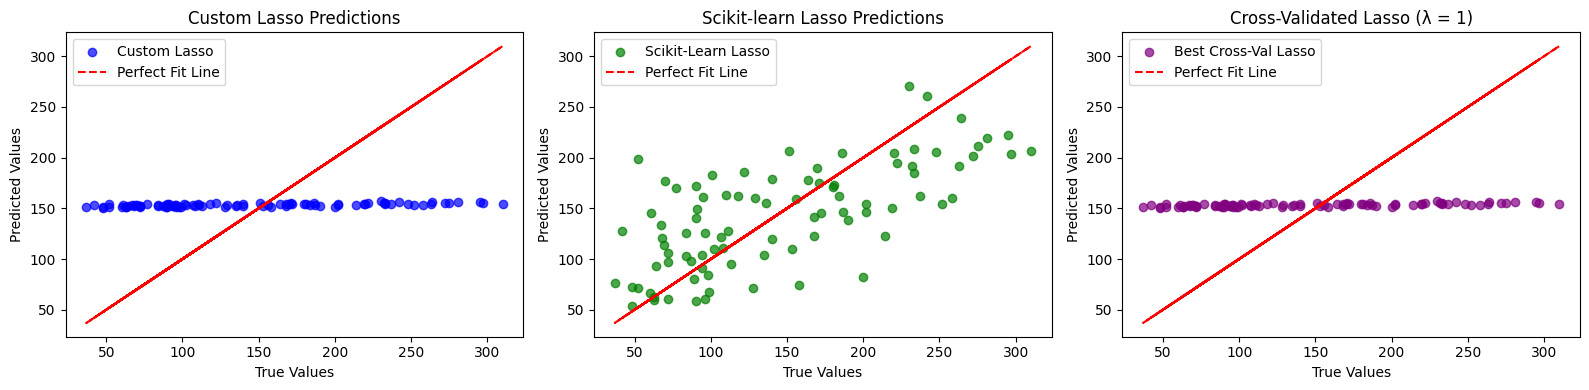

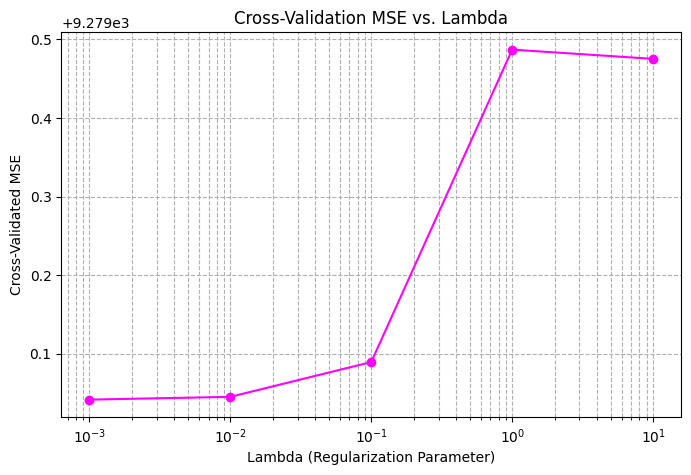

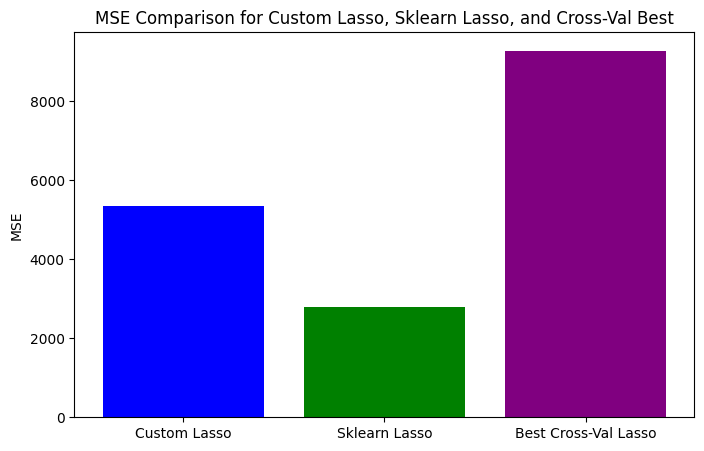

In [48]:
# --- Plot 1: Predictions vs. True Values ---
plt.figure(figsize=(16, 4))

# Custom Lasso Predictions
plt.subplot(1, 3, 1)
plt.scatter(y_test, final_custom_y_pred, color='blue',
            label='Custom Lasso', alpha=0.7)
plt.plot(y_test, y_test, color='red',
         linestyle='dashed', label='Perfect Fit Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Custom Lasso Predictions')
plt.legend()

# Scikit-learn Lasso Predictions
plt.subplot(1, 3, 2)
plt.scatter(y_test, final_sklearn_y_pred, color='green',
            label='Scikit-Learn Lasso', alpha=0.7)
plt.plot(y_test, y_test, color='red',
         linestyle='dashed', label='Perfect Fit Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Scikit-learn Lasso Predictions')
plt.legend()

# Final Cross-Validated Lasso Predictions
plt.subplot(1, 3, 3)
plt.scatter(y_test, final_custom_y_pred, color='purple',
            label='Best Cross-Val Lasso', alpha=0.7)
plt.plot(y_test, y_test, color='red',
         linestyle='dashed', label='Perfect Fit Line')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title(f'Cross-Validated Lasso (λ = {best_lambda})')
plt.legend()

plt.tight_layout()
plt.show()

# --- Plot 2: MSE vs. Lambda ---
plt.figure(figsize=(8, 5))
plt.plot(list(lambda_mse_scores.keys()), list(
    lambda_mse_scores.values()), marker='o', color='magenta')
plt.xlabel('Lambda (Regularization Parameter)')
plt.ylabel('Cross-Validated MSE')
plt.title('Cross-Validation MSE vs. Lambda')
plt.xscale('log')
plt.grid(True, linestyle='--', which='both')
plt.show()

# --- Plot 3: MSE Comparison (Custom vs. Sklearn vs. Cross-Val) ---
mse_values = [mse_custom, mse_sklearn, mse_cross_val_best]
mse_labels = ['Custom Lasso', 'Sklearn Lasso', 'Best Cross-Val Lasso']

plt.figure(figsize=(8, 5))
plt.bar(mse_labels, mse_values, color=['blue', 'green', 'purple'])
plt.ylabel('MSE')
plt.title('MSE Comparison for Custom Lasso, Sklearn Lasso, and Cross-Val Best')
plt.show()

# ElasticNet

Implmentation

In [34]:
class elasticNet:
  def __init__(self, Lambda, Alpha,no_of_iterations,lr): # lambda is l1_penalty ,alpha is l2 penalty 
    self.Lambda = Lambda
    self.Alpha = Alpha
    self.no_of_iterations = no_of_iterations
    self.lr = lr
    self.shapeX = X_train.shape[0]
    self.shapeY = X_train.shape[1]

    self.w = np.zeros(self.shapeY)

    self.b = 0
    

  def weightUpdate(self):
    y_pred = self.predict(self.X_train)
    dW = np.zeros(self.shapeY) #initialized with zeros then will be updated based on no_of_iterations parameter
    for i in range(self.shapeY):
      if self.w[i]>0:
        dW[i] = ( - ( 2 * ( self.X_train[:,i] ).dot( self.Y_train - y_pred ) ) + self.Lambda + 2 * self.Alpha * self.w[i] ) / self.shapeX 
      else:
        dW[i] = ( - ( 2 * ( self.X_train[:,i] ).dot( self.Y_train - y_pred ) )- self.Lambda + 2 * self.Alpha * self.w[i] ) / self.shapeX 
      db = -2 * np.sum(self.Y_train - y_pred)/self.shapeX
      self.w = self.w - self.lr * dW
      self.b = self.b - self.lr * db

      return self
  def fit(self,X_train,Y_train):
    self.X_train = X_train

    self.Y_train = Y_train

    for i in range(self.no_of_iterations):
      self.weightUpdate()

    return self

  def predict(self,X_test):
    return X_test.dot(self.w) + self.b




Performance

In [35]:
elastic = elasticNet(0.1,0.3, 500,0.1)
elastic.fit(X_train,y_train)
y_predict = elastic.predict(X_test)
acc = mean_squared_error(y_test,y_predict)
print(acc)

ValueError: setting an array element with a sequence.

Visualize

Performance for sklearn Model

In [ ]:
elasticSklearn = ElasticNet(alpha=0.3,l1_ratio=0.1,max_iter=500)
elasticSklearn.fit(X_train,y_train)
y_predict = elasticSklearn.predict(X_test)
acc = mean_squared_error(y_test,y_predict)
print(acc)

5704.680682647094


Visualize